# Test 4
Same as test 3,

* Fixed external magnetic field at 60 deg.
* Ramp for 60s
* Evolution for 120s


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import getVerticesDict, getVerticesCount, getVerticesAverage

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running the simulations

In [2]:
def getSimulation():
    sp = ice.spins()

    # Initialize some parameters
    trapSep = 10*ureg.um
    particleRadius = 5*ureg.um
    totalTime = 180*ureg.s

    L = 30*ureg.um
    N = 10

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

    particle = ice.particle(radius = particleRadius,
                susceptibility = 0.0576,
                diffusion = 0.125*ureg.um**2/ureg.s,
                temperature = 300*ureg.K,
                density = 1000*ureg.kg/ureg.m**3)

    trap = ice.trap(trap_sep = trapSep,
                height = 4*ureg.pN*ureg.nm,
                stiffness = 1e-3*ureg.pN/ureg.nm)

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = 0, 
                            susceptibility_spread = 0.1,
                            periodic = True)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    framespersec = 50*ureg.Hz;
    dt = 10*ureg.ms

    world = ice.world(
        field = 5*ureg.mT,
        temperature = 300*ureg.K,
        dipole_cutoff = 200*ureg.um)


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = framespersec,
                timestep = dt,
                run_time = totalTime,
                output = ["x","y","z","mux","muy","muz"])

    # Field
    col.sim.field.fieldx = "v_Bmag*sin(PI/3)*time/60e6*(time<60e6)+v_Bmag*sin(PI/3)*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "v_Bmag*cos(PI/3)*time/60e6*(time<60e6)+v_Bmag*cos(PI/3)*(time>=60e6)"

    col.run_simulation();

    col.load_simulation()

    return col

In [ ]:
runs = 10

for i in range(1,runs+1):
    print(f"===== Experiment number {i} =====")
    col = getSimulation()

    filename = f"trj{i}.csv"
    print(filename)
    col.trj.to_csv('../data/test4/trj/' + filename)
    print('Saved trj')
    
    filename = f"ctrj{i}.csv"
    print(filename)
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv('../data/test4/ctrj/' + filename)
    print('Saved centered trj')

# Getting vertices

In [ ]:
trjPath = "../data/test4/trj/"
ctrjPath = "../data/test4/ctrj/"
verticesPath = "../data/test4/vertices/"

# Get the number of realizations
_, _, files = next(os.walk(trjPath))
realizations = len(files)

for i in range(1,realizations+1):
    print("============================================================")
    print(f"Working on realization {i}")

    # Importing files
    trjFile = trjPath + f"trj{i}.csv"
    print(f"Opening " + trjFile)
    ctrjFile = ctrjPath + f"ctrj{i}.csv"
    print(f"Opening " + ctrjFile)
    trj_raw = trj = pd.read_csv(trjFile, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrjFile, index_col=[0,1])

    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    verticesFile = verticesPath + f"vertices{i}.csv"
    v.trj_to_vertices(ctrj_raw.loc[frames[::10]])

    print(f"Saving vertices to " + verticesFile)
    v.vertices.to_csv(verticesFile)

# Analysis

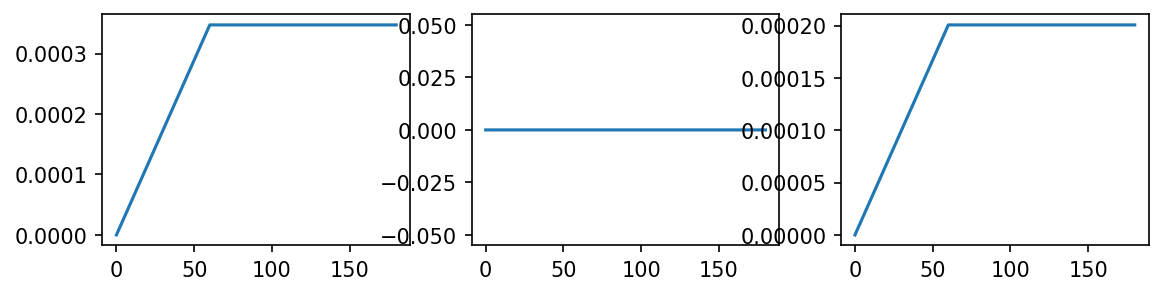

In [10]:
trj_raw = trj = pd.read_csv("../data/test4/trj/trj10.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test4/ctrj/ctrj10.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))

In [ ]:
# Import and classify the vertices
verticesFolderPath = "../data/test4/vertices/"
vertices = getVerticesDict(verticesFolderPath)
vertices["10"]

In [ ]:
counts = getVerticesCount(vertices)
counts["10"]

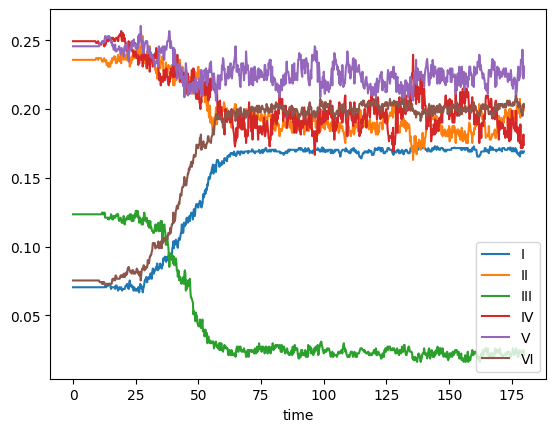

In [16]:
timeSeries = getVerticesAverage(counts,50)
ax = plt.gca()
types = timeSeries.columns.to_list()[1:]
for col in types:
    timeSeries.plot(kind='line',
        x='time',
        y=col,
        ax=ax
        )


In [ ]:
rampSeries = timeSeries[timeSeries['time'] <= 60]
evoSeries = timeSeries[timeSeries['time'] > 60]

rampSeries["field"] = 5 * rampSeries["time"]/60
evoSeries["offtime"] = (evoSeries["time"]-60)

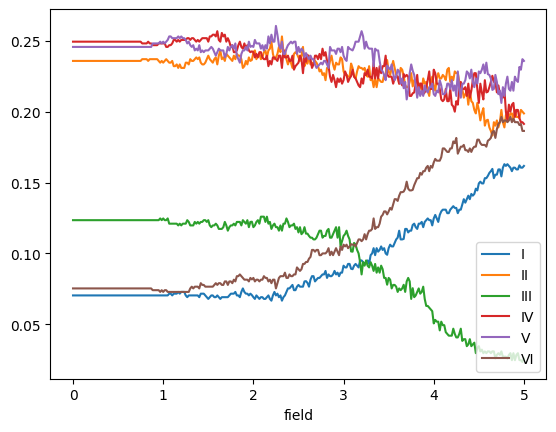

In [18]:
ax = plt.gca()
for col in types:
    rampSeries.plot(kind='line',
        x='field',
        y=col,
        ax=ax
        )

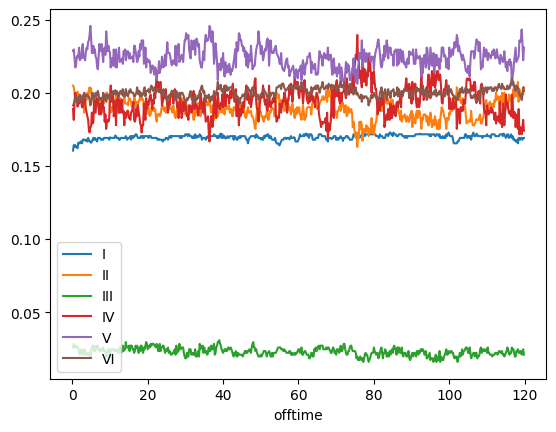

In [19]:
ax = plt.gca()
for col in types:
    evoSeries.plot(kind='line',
        x='offtime',
        y=col,
        ax=ax
        )

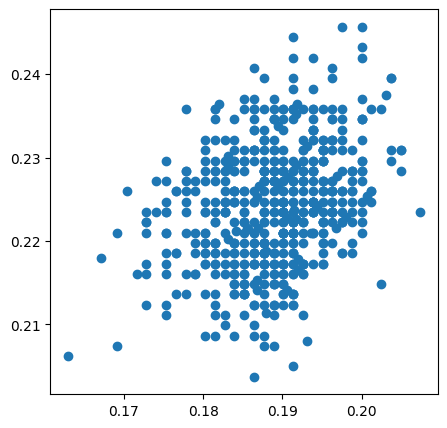

In [20]:
type1 = evoSeries["I"]
type2 = evoSeries["II"]
type4 = evoSeries["IV"]
type5 = evoSeries["V"]
type6 = evoSeries["VI"]

f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type2,type5)

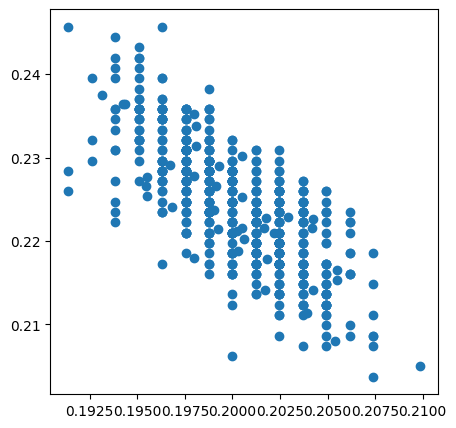

In [21]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type6,type5)

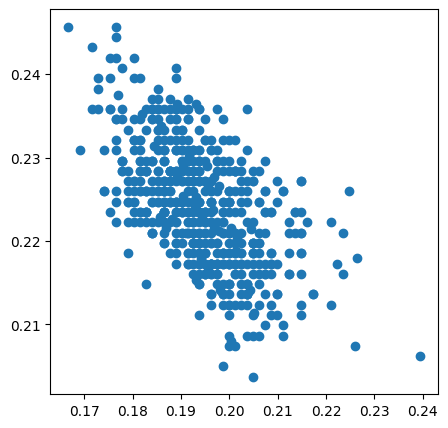

In [22]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type4,type5)

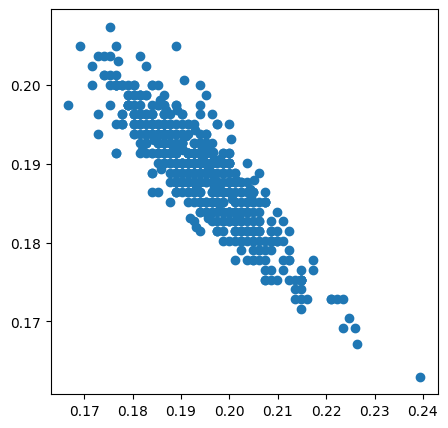

In [23]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type4,type2)